# Data Audit and Problem Discovery Notebook 

This notebook provides a reusable set of checks for:
- Structural sanity (shape, dtypes, duplicates)
- Missingness patterns 
- Distributions 
- Type consistency 
- Outliers 
- Basic time-series checks (if date column is present)

Configure:
- `CSV_PATH`
- `DATE_COLS`
- `INDEX_COL`
- `DATE_COL_FOR_TS`

## Config

In [25]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

sns.set()

CSV_PATH = "testing.csv"             # <- change this
INDEX_COL = None                     # or e.g. "id"
DATE_COLS = ["date"]                 # e.g. ["date"]
DATE_COL_FOR_TS = None               # e.g. "date" if time-series

READ_CSV_KWARGS = {
    "header": "infer",   # or None if your file has no header row
    # "sep": ",",        # set if not comma
    # "encoding": "utf-8",
}

## Data 

In [26]:
df = pd.read_csv(
    CSV_PATH,
    index_col=INDEX_COL,
    **READ_CSV_KWARGS
)

# Parse date columns if specified
for col in DATE_COLS:
    df[col] = pd.to_datetime(df[col], format="%d/%m/%Y", errors="coerce")

df.head()

,date,transaction_amount,transaction_info,account_balance
0,NaT,-17.00,9 DEGREES WATERLOO TARINGA QL AUS Card xx6601 ...,191.36
1,2026-01-01,-17.00,9 DEGREES WATERLOO TARINGA QL AUS Card xx6601 ...,191.36
2,2026-01-01,-33.99,CHEMIST WAREHOUSE SYDNEY NS AUS Card xx6601 Va...,208.36
3,2026-01-01,-10.00,TRANSPORTFORNSW OPAL CHIPPENDALE AUS Card xx66...,242.35
4,2025-12-31,-4.00,MCDONALDS SYD CTRL P SYDNEY NS AUS Card xx6601...,252.35


## Audit

In [27]:
def structural_report(df: pd.DataFrame) -> dict:
    # Returns basic structure of df, missing values, duplicates, dtypes 
    return {
        "n_rows": len(df),
        "n_cols": df.shape[1],
        "n_missing": df.isna().mean().sort_values(),
        "n_duplicates": df.duplicated().sum(),
        "dtypes": df.dtypes.sort_index()
    }

def iqr_outlier_fraction(s: pd.Series) -> float:
    # Returns values that are probably outliers 1.5* IQR
    s = s.dropna()
    if s.empty:
        return np.nan 
    q1, q3 = np.percentile(s, [25,75])
    iqr = q3 - q1
    if iqr == 0:
        return 0.0
    mask = (s < q1 - 1.5 * iqr) | (s > q3 + 1.5 * iqr)
    return mask.mean()

def numeric_summary(df: pd.DataFrame) -> pd.DataFrame:
    # Returns simple information about dataframe such as count,mean,std, quartiles and outerliers
    num = df.select_dtypes(include=["number"])
    if num.empty:
        return pd.DataFrame()
    desc = num.describe().T 
    desc["outlier_frac"] = num.apply(iqr_outlier_fraction)
    return desc 

def categorical_summary(df: pd.DataFrame, top_k: int = 10) -> dict:
    # For each categorical column, give cardinality and top-k frequencies
    cat_cols = df.select_dtypes(include=["object", "category"]).columns
    summary = {}
    for col in cat_cols:
        vc = df[col].value_counts(dropna=False) # gives the count of each unique value in the column
        summary[col] = {
            "n_unique": df[col].nunique(dropna=True),
            "top_values": vc.head(top_k),
        }
    return summary


def numeric_string_candidates(df: pd.DataFrame, sample_n: int = 5) -> dict:
    # Find object columns that look numeric 
    candidates = {}
    obj_cols = df.select_dtypes(include=["object"]).columns
    for col in obj_cols:
        try:
            converted = pd.to_numeric(df[col].dropna())
            if not converted.empty:
                candidates[col] = df[col].dropna().sample(
                    min(sample_n, len(df[col].dropna())),
                    random_state=0
                )
        except Exception:
            continue
    return candidates


In [28]:
def plot_missing_heatmap(df: pd.DataFrame, max_rows: int = 1000):
    """Heatmap of missingness (downsample if too many rows)."""
    data = df
    if len(df) > max_rows:
        data = df.sample(max_rows, random_state=0)
    plt.figure(figsize=(10, 6))
    sns.heatmap(data.isna(), cbar=False)
    plt.title("Missing Data Pattern (sampled)" if len(df) > max_rows else "Missing Data Pattern")
    plt.xlabel("Columns")
    plt.ylabel("Rows")
    plt.show()


def plot_missing_bar(df: pd.DataFrame):
    """Bar plot of missing fraction per column."""
    missing_pct = df.isna().mean().sort_values(ascending=False)
    plt.figure(figsize=(10, 4))
    missing_pct.plot.bar()
    plt.title("Missing Value Proportion per Column")
    plt.ylabel("Fraction missing")
    plt.show()


def plot_numeric_distributions(df: pd.DataFrame):
    """Histograms for numeric columns."""
    num = df.select_dtypes(include=["number"])
    if num.empty:
        print("No numeric columns to plot.")
        return
    num.hist(bins=30, figsize=(12, 8))
    plt.tight_layout()
    plt.show()


def plot_numeric_boxplots(df: pd.DataFrame):
    """Boxplots for numeric columns."""
    num = df.select_dtypes(include=["number"])
    if num.empty:
        print("No numeric columns to plot.")
        return
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=num, orient="h")
    plt.title("Numeric Columns – Boxplots")
    plt.show()


def plot_categorical_bars(df: pd.DataFrame, max_cols: int = 10, top_k: int = 10):
    """Bar plots for the most frequent categories in up to `max_cols` categorical columns."""
    cat_cols = df.select_dtypes(include=["object", "category"]).columns[:max_cols]
    for col in cat_cols:
        vc = df[col].value_counts().head(top_k)
        plt.figure(figsize=(8, 3))
        vc.plot.bar()
        plt.title(f"{col} – top {top_k}")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()


def plot_correlation_heatmap(df: pd.DataFrame):
    """Correlation heatmap for numeric columns."""
    num = df.select_dtypes(include=["number"])
    if num.empty:
        print("No numeric columns for correlation.")
        return
    plt.figure(figsize=(10, 8))
    corr = num.corr()
    sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
    plt.title("Correlation Heatmap (numeric)")
    plt.show()


=== STRUCTURE ===
Rows: 601
Cols: 4

Dtypes:
 account_balance              float64
date                  datetime64[ns]
transaction_amount           float64
transaction_info              object
dtype: object

Missing fraction per column:
 transaction_amount    0.000000
transaction_info      0.000000
account_balance       0.000000
date                  0.001664
dtype: float64

Duplicate rows: 0


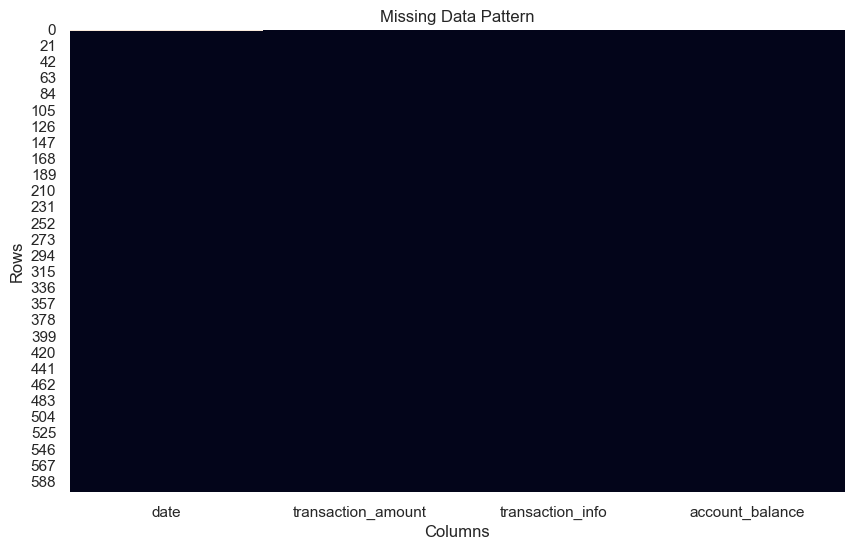

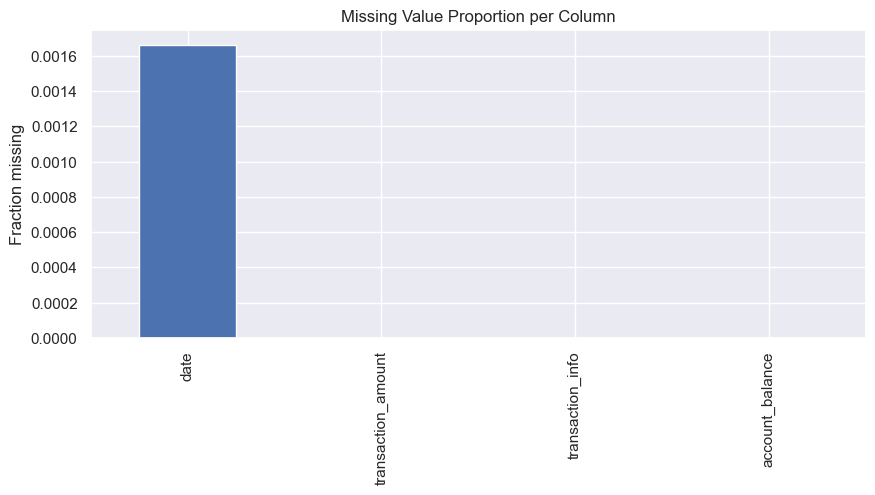


=== NUMERIC SUMMARY ===


,count,mean,std,min,25%,50%,75%,max,outlier_frac
transaction_amount,601.0,-0.109684,645.991556,-6031.45,-21.64,-10.00,-5.00,5500.00,0.307820
account_balance,601.0,735.329418,1172.683436,32.60,225.78,377.31,674.93,6812.52,0.118136


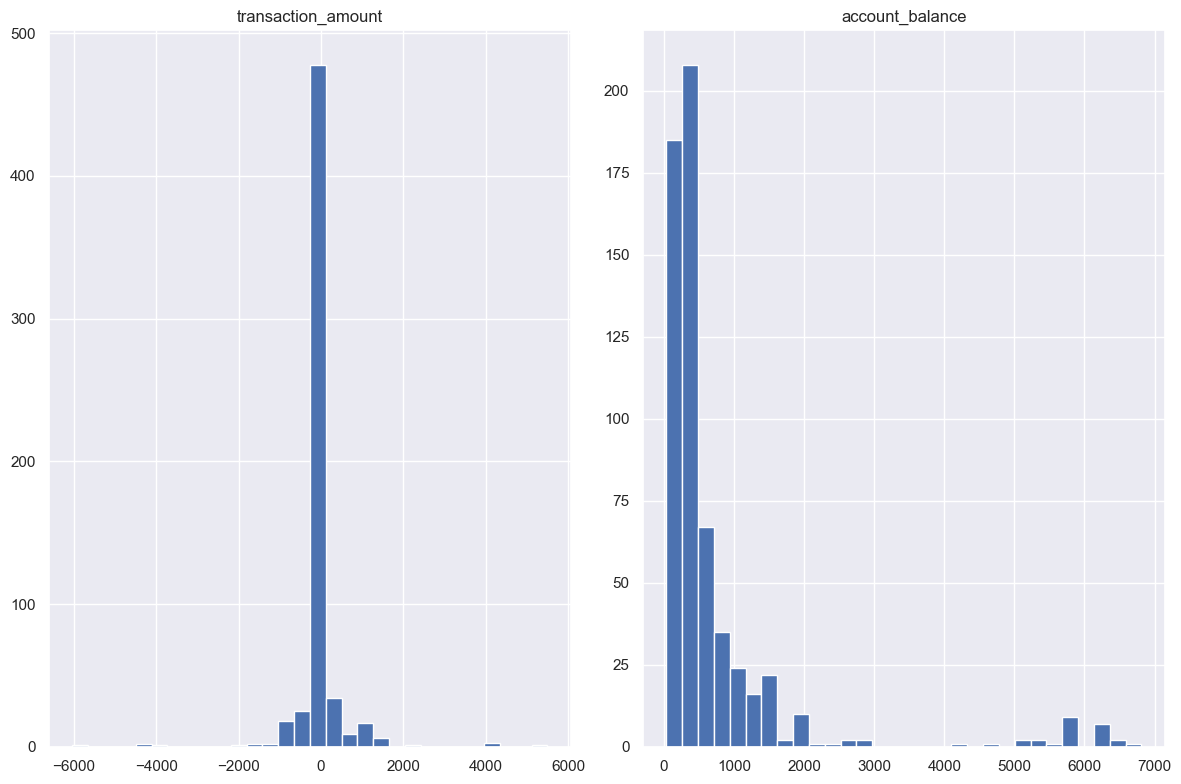

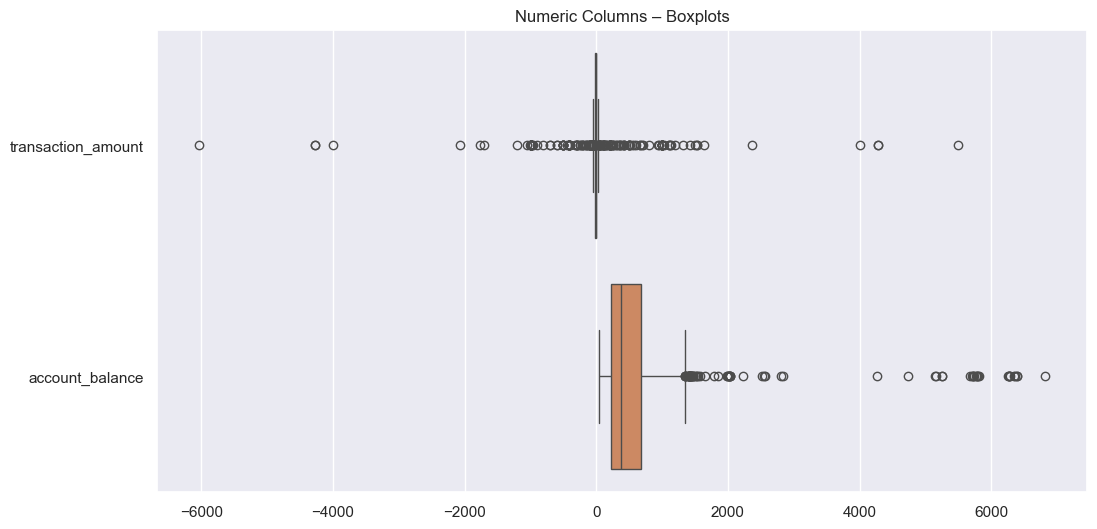

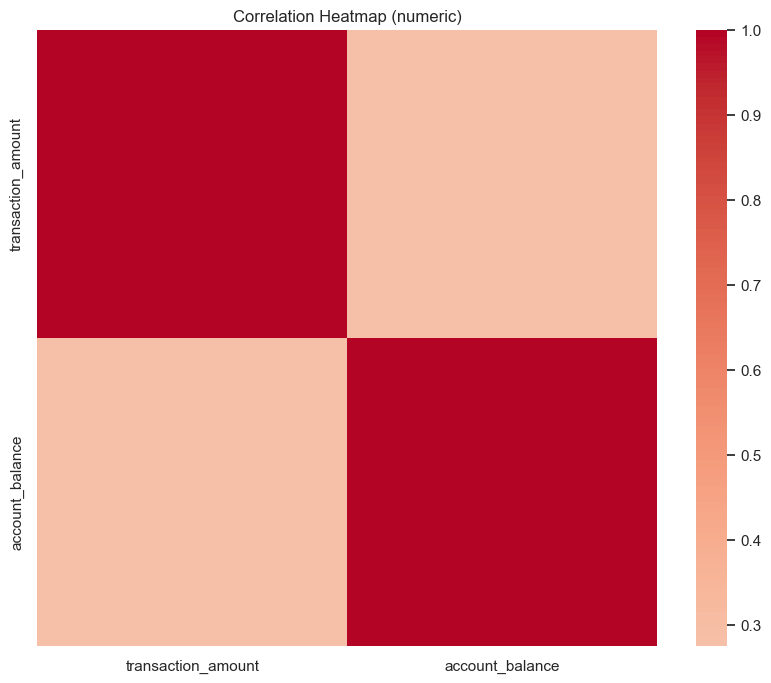


=== CATEGORICAL SUMMARY ===

Column: transaction_info
Unique values: 498
Top values:
transaction_info
Transfer from xx6908 CommBank app                                      22
Salary DAVID JONES LTD NSWA 331076                                     14
Transfer to xx6908 CommBank app                                        10
Transfer to xx6908 NetBank My holiday goal                              9
Refund Purchase Beem It                                                 5
Transfer To moomoo AU PayID Email from CommBank App investment          4
AMAZON AU MARKETPLACE SYDNEY AUS Card xx6601 Value Date: 27/12/2025     4
Transfer to xx6908 CommBank app savings                                 4
TRANSPORTFORNSW TAP SYDNEY AUS Card xx6601 Value Date: 01/12/2025       4
Transfer to xx6908 CommBank app hi                                      4
Name: count, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_15692\23369542.py:56: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


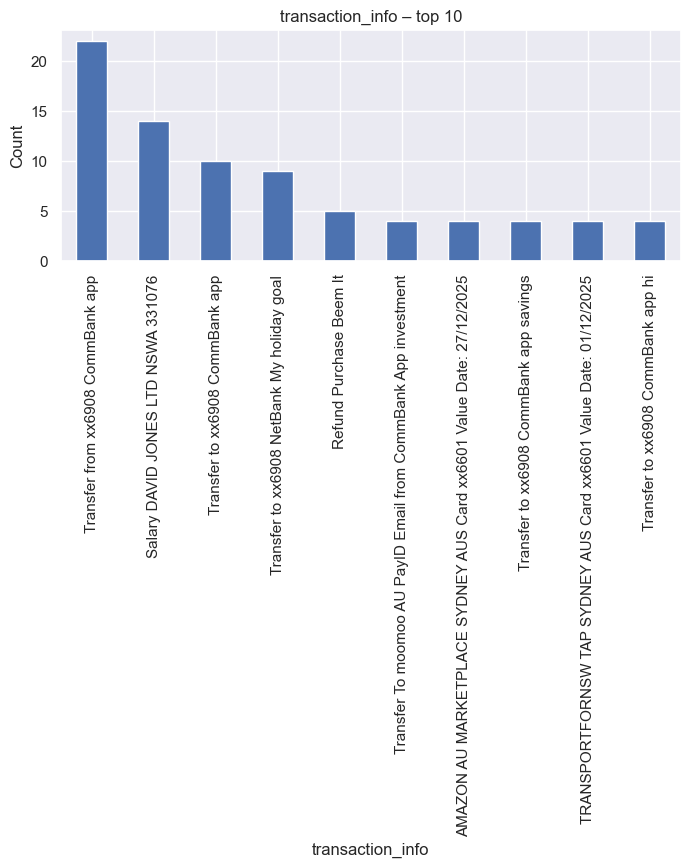


=== NUMERIC-LOOKING STRING COLUMNS ===


In [29]:
# 1. Structural report
struct = structural_report(df)
print("=== STRUCTURE ===")
print(f"Rows: {struct['n_rows']}")
print(f"Cols: {struct['n_cols']}")
print("\nDtypes:\n", struct["dtypes"])
print("\nMissing fraction per column:\n", struct["n_missing"])
print("\nDuplicate rows:", struct["n_duplicates"])

# 2. Missingness visuals
plot_missing_heatmap(df)
plot_missing_bar(df)

# 3. Numeric summaries + visuals
print("\n=== NUMERIC SUMMARY ===")
display(numeric_summary(df))

plot_numeric_distributions(df)
plot_numeric_boxplots(df)
plot_correlation_heatmap(df)

# 4. Categorical summaries + visuals
print("\n=== CATEGORICAL SUMMARY ===")
cat_summary = categorical_summary(df, top_k=10)
for col, info in cat_summary.items():
    print(f"\nColumn: {col}")
    print("Unique values:", info["n_unique"])
    print("Top values:")
    print(info["top_values"])

plot_categorical_bars(df, max_cols=10, top_k=10)

# 5. Type consistency: numeric-looking string columns
print("\n=== NUMERIC-LOOKING STRING COLUMNS ===")
num_str_candidates = numeric_string_candidates(df)
for col, sample_vals in num_str_candidates.items():
    print(f"\nColumn: {col}")
    print("Sample values that look numeric:")
    print(sample_vals)